# Image Captioning with Attention Mechanism

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y tensorflow estimator keras
!pip install -U tensorflow_text  tensorflow_datasets
!pip install tensorflow
!pip install einops

In [2]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request
import seaborn as sns
from matplotlib import cm

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests

import tensorflow as tf
import tensorflow_hub as hub 
import tensorflow_text as text
import tensorflow_datasets as tfds

import nltk.translate.bleu_score as bleu_score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction


import pathlib
from pathlib import Path
from humanize import naturalsize

sns.set()
sns.set_palette("flare")
color = cm.plasma(np.linspace(.4, .8, 30))


import tqdm
from tqdm import notebook





In [3]:
# Helper funtion to preview images
def preview_image(image_path):
  img = plt.imread(image_path)
  plt.imshow(img)
  plt.show()



In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

DRIVE_DIR = '/content/drive/MyDrive/'
IMAGE_DIR = '/content/drive/MyDrive/image_dir/'
DATA_DIR = '/content/drive/MyDrive/image_caption_data/'

Mounted at /content/drive
/content/drive/MyDrive


## Dataset

In [5]:
# Paths to data files
captions_file = DATA_DIR + 'captions_new.csv'
train_files_list = DATA_DIR + 'train_files.csv'
test_files_list = DATA_DIR + 'test_files.csv'

### Dataset to tf.data.Dataset format

We will merge the images with their respective captions and store the in a tf.data.Dataset




In [8]:
path = DRIVE_DIR
IMAGE_DIR_ext="image_dir"
path = Path(path)
  
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
   
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
  cap_dict[fname].append(cap)
   
train_files = (path/train_files_list).read_text().splitlines()
# Keep the top X% of the files
dataset_percentage = 1.0
train_files = random.sample(train_files, k=int(len(train_files) * dataset_percentage))
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
   
test_files = (path/test_files_list).read_text().splitlines()
test_files = random.sample(test_files, k=int(len(test_files) * dataset_percentage))
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]
   

train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)


### Image feature extractor

In [9]:
IMAGE_SHAPE=(224, 224, 3)
efficientnet = tf.keras.applications.EfficientNetB0(
    input_shape=IMAGE_SHAPE,
    include_top=False)
efficientnet.trainable=False



16705208/16705208 [==============================] - 0s 0us/step


In [10]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  preview_image(ex_path.numpy().decode())
  print(ex_path)
  print(ex_captions)

In [14]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(efficientnet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 1280)


### Setup text tokenizer/vectorizer


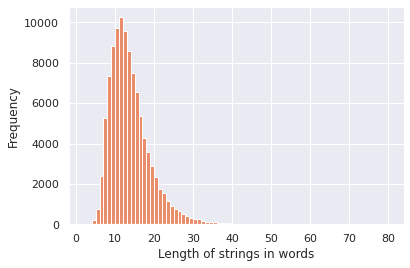

In [15]:
# Histogram
train_caption_list = [lst for _, lst in train_captions]

caption_lengths = [len(string.split()) for string_list in train_caption_list for string in string_list]

# Plot a histogram of the lengths
plt.hist(caption_lengths, bins=range(min(caption_lengths), max(caption_lengths) + 2))
plt.xlabel('Length of strings in words')
plt.ylabel('Frequency')
plt.show()


As we can see, a range of 0-30 word length in each caption will be optimal.



In [16]:
import re
import string
import nltk
from nltk.corpus import stopwords
import tensorflow as tf

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [18]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [19]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

In [20]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 755, 5, 2, 63, 4], [3, 2, 2866, 34, 4]]>

In [21]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [22]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [23]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Dataset preparation

In [24]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [25]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [26]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [27]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

You could install the feature extractor in your model and train on the datasets like this:

In [28]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [29]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`: 

In [30]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [31]:
save_dataset(train_raw, 'train_cache', efficientnet, tokenizer, batch_size=32)
save_dataset(test_raw, 'test_cache', efficientnet, tokenizer, batch_size=32)

657it [42:40,  3.90s/it]
142it [10:18,  4.35s/it]


### Load ready Dataset

In [32]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [33]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 1280), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [34]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 1280)
(32, 19)
(32, 19)


The input tokens and the labels are the same, just shifted by 1 step:

In [35]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   9  12   2  24  23   8  28 128  40  51   2  24 281 275   2  77   0
   0]
[  9  12   2  24  23   8  28 128  40  51   2  24 281 275   2  77   4   0
   0]


### Input

The input text has already been split up into tokens and converted to sequences of IDs. 

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.



In [36]:
# class SeqEmbedding(tf.keras.layers.Layer):
#   def __init__(self, vocab_size, max_length, depth):
#     super().__init__()
#     self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

#     self.token_embedding = tf.keras.layers.Embedding(
#         input_dim=vocab_size,
#         output_dim=depth,
#         mask_zero=True)
    
#     self.add = tf.keras.layers.Add()

#   def call(self, seq):
#     seq = self.token_embedding(seq) # (batch, seq, depth)

#     x = tf.range(tf.shape(seq)[1])  # (seq)
#     x = x[tf.newaxis, :]  # (1, seq)
#     x = self.pos_embedding(x)  # (1, seq, depth)

#     return self.add([seq,x])

import gensim.downloader as gensim_api


class SeqEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, max_length, depth):
        super().__init__()
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
        
        # Load the Gensim word2vec model
        # self.word2vec = gensim.models.Word2Vec.load("glove-wiki-gigaword-50")
        # word_vectors = self.word2vec.wv

        word2vec = gensim_api.load("glove-wiki-gigaword-200")
        word_vectors = word2vec.wv

        # Initialize the token embedding layer with pre-trained weights
        self.token_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=depth,
            weights=[word_vectors.vectors],
            trainable=False,
            mask_zero=True)

        self.add = tf.keras.layers.Add()

    def call(self, seq):
        seq = self.token_embedding(seq)  # (batch, seq, depth)

        x = tf.range(tf.shape(seq)[1])  # (seq)
        x = x[tf.newaxis, :]  # (1, seq)
        x = self.pos_embedding(x)  # (1, seq, depth)

        return self.add([seq,x])


### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`.

The `CausalSelfAttention` layer is below:

In [37]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [38]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [39]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [40]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [41]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [42]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 3282/3282 [05:21<00:00, 10.19it/s]


Uniform entropy: 8.52
Marginal entropy: 5.47


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [75]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=30, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [76]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [77]:
model = Captioner(tokenizer, feature_extractor=efficientnet, output_layer=output_layer,
                  units=512, dropout_rate=0.5, num_layers=2, num_heads=2)

<ipython-input-36-481bfd1977c6>:35: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_vectors = word2vec.wv


### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [78]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.


In [79]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [80]:
@Captioner.add_method
def beam_search(self, image, beam_width=3, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])
  
  # Initialize the beams with the initial token
  beams = [{'tokens': initial, 'log_probs': 0}]

  # Repeat until all beams have reached the end token or the maximum number of steps
  for n in range(50):
    new_beams = []
    for beam in beams:
      preds = self((img_features, beam['tokens'])).numpy()  # (batch, sequence, vocab)
      preds = preds[:,-1, :]  #(batch, vocab)
      if temperature==0:
        next_word_probs = tf.math.softmax(preds)  # convert to probabilities
      else:
        next_word_probs = tf.math.softmax(preds / temperature)  # convert to probabilities
      next_word_probs = next_word_probs.numpy()[0]  # remove the batch dimension
      
      # Get the top 'beam_width' words and their corresponding log probabilities
      next_word_probs, next_word_indices = tf.math.top_k(next_word_probs, k=beam_width)
      
      for word_log_prob, word_index in zip(next_word_probs.numpy(), next_word_indices.numpy()):
        new_beam = {
            'tokens': tf.concat([beam['tokens'], [[word_index]]], axis=1),
            'log_probs': beam['log_probs'] + np.log(word_log_prob)
        }
        new_beams.append(new_beam)

    beams = sorted(new_beams, key=lambda x: x['log_probs'], reverse=True)[:beam_width]

    # Exit loop if the end token is found
    if any(beam['tokens'][0,-1] == self.word_to_index('[END]') for beam in beams):
      break

  # Return the sentence with the highest log probability
  best_beam = max(beams, key=lambda x: x['log_probs'])
  words = index_to_word(best_beam['tokens'][0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`). 

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model we need 3 components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

An implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [81]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [82]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


It generates three output strings, like the earlier example, like before the first is "greedy", choosing the argmax of the logits at each step.

In [84]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a of
in
several a street women sunglasses shirt hard front grass



Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [85]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

Configure and execute the training.

In [86]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`. 


In [87]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 4.6880 - masked_acc: 0.2170

a man in a red shirt is playing the water
a boy in a black shirt is playing the field
lawn with young shirtless other towards clothes dressed and pool

100/100 [==============================] - 33s 170ms/step - loss: 4.6880 - masked_acc: 0.2170 - val_loss: 4.2583 - val_masked_acc: 0.2587
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.1964 - masked_acc: 0.2634

a man in a blue shirt is jumping
a man in a yellow shirt and white dog is running in the background
a boy waters in the skis

100/100 [==============================] - 19s 188ms/step - loss: 4.1964 - masked_acc: 0.2634 - val_loss: 4.0242 - val_masked_acc: 0.2774
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.0304 - masked_acc: 0.2798

a man in a blue shirt is jumping on a pool
a man in a blue shirt is jumping in the middle
the boy in a shirt swimming is running that

100/100 [==

Plot the loss and accuracy over the training run:

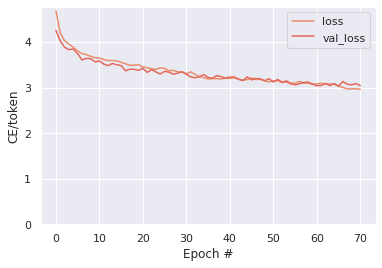

In [88]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

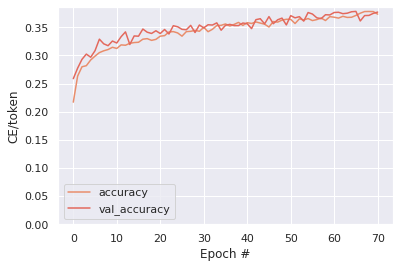

In [89]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [90]:
result = model.simple_gen(image, temperature=0.0)
result

'a surfer is surfing on a wave'

Split the output back into tokens:

In [91]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [92]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 8, 49]), TensorShape([1, 2, 8, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [93]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [94]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [95]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

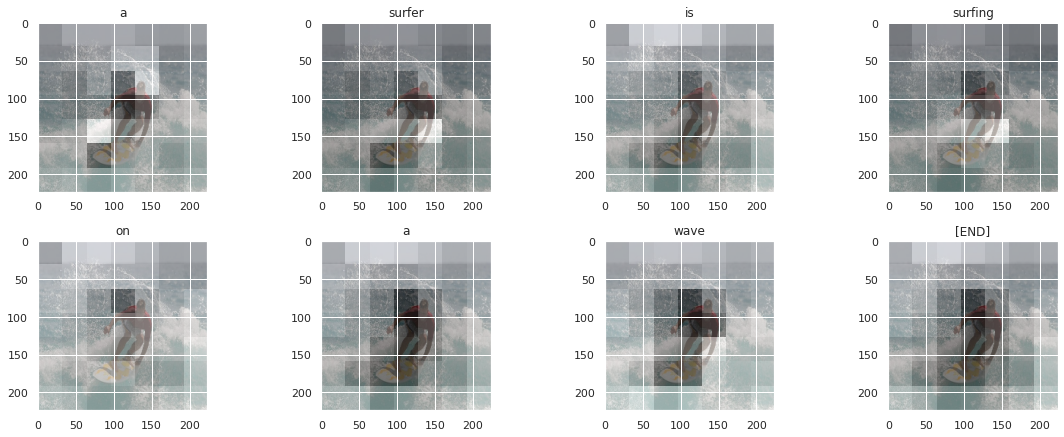

In [96]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [97]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


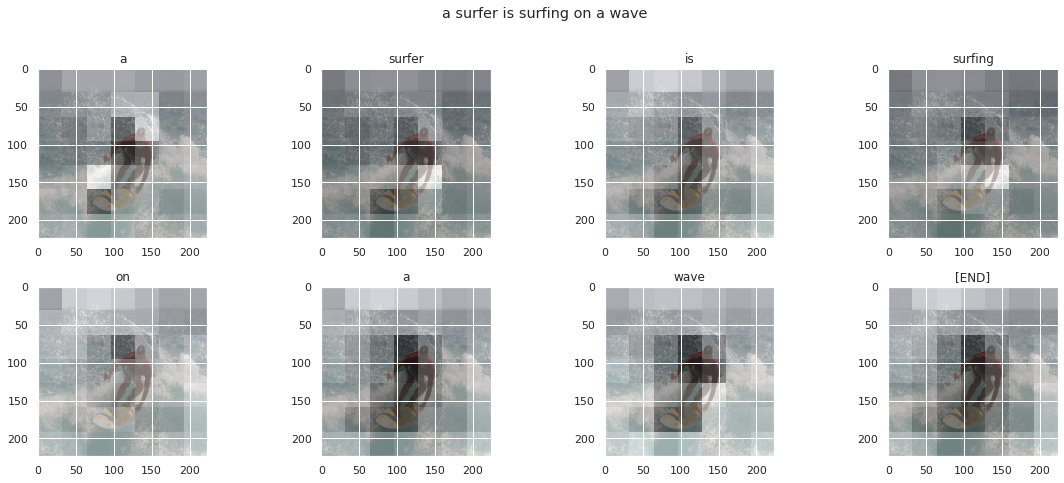

In [98]:
run_and_show_attention(model, image)

## Trial

We try our network on a random image.

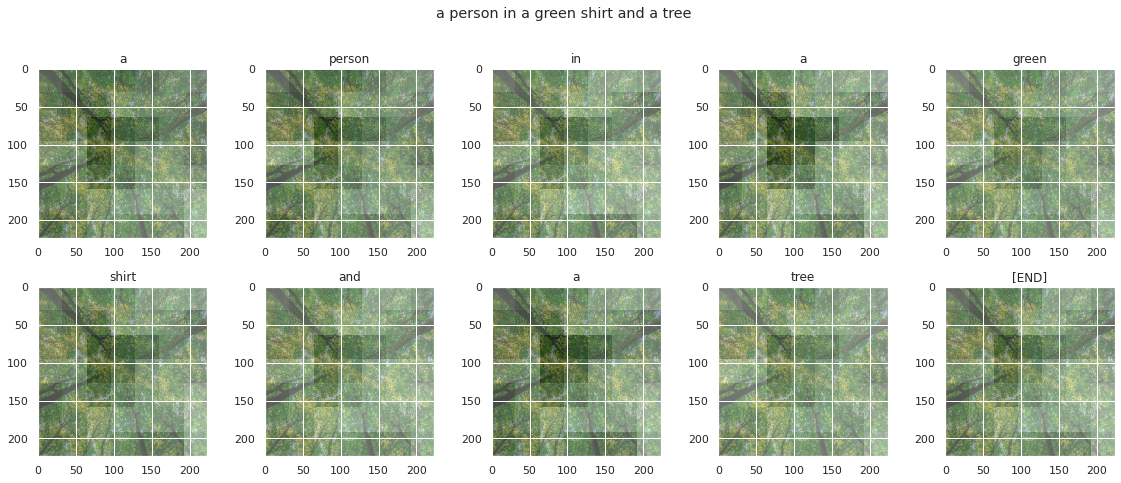

In [99]:
image_url = 'https://api.time.com/wp-content/uploads/2018/05/forest-bathing.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)

### Model prediction


In [100]:
# This function takes an image path and generates a hypothesis for it
def predict_caption(image_path, temperature=0.0):
  image = load_image(image_path)
  return model.beam_search(image, temperature=temperature)

def predict_caption_list(image_path, temperature=0.0):
  image = load_image(image_path)
  return model.beam_search(image, temperature=temperature).split()
  

### Bleu score calculation

In [101]:
# Prepare the test dataset captions
test_images_list = [lst for lst, _ in test_captions]
test_caption_list = [lst for _, lst in test_captions]


In [102]:
def evaluate_caption_BLEU(hypothesis, references):
    weights = (0.4, 0.3, 0.2, 0.1)
    smoothing_function = SmoothingFunction().method1
    score = sentence_bleu(references, hypothesis, weights=weights, smoothing_function=smoothing_function)
    return score



def evaluate_corpus_BLEU(hypotheses, references):
    weights = (0.4, 0.3, 0.2, 0.1)
    smoothing_function = SmoothingFunction().method1
    score = corpus_bleu(references, hypotheses,weights=weights, smoothing_function=smoothing_function)
    return score




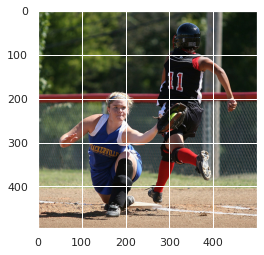

Temperature = 0.0
Caption hypothesis: a young boy in a red jersey is playing baseball
The BLUE score for image: /content/drive/MyDrive/image_dir/_708248940.jpg is 0.001511016135268074

Temperature = 1.0
Caption hypothesis: a young boy in a red jersey is playing baseball
The BLUE score for image: /content/drive/MyDrive/image_dir/_708248940.jpg is 0.001511016135268074



In [103]:
# Example of evaluate_caption
preview_image(test_images_list[1])


prediction = predict_caption_list(test_images_list[1], 0.0) 
score = evaluate_caption_BLEU(prediction, test_caption_list[0])
print("Temperature = 0.0")
print("Caption hypothesis:", " ".join(prediction))
print("The BLUE score for image:", test_images_list[0], "is", score)
print() 


prediction = predict_caption_list(test_images_list[1], 1.0) 
score = evaluate_caption_BLEU(prediction, test_caption_list[0])
print("Temperature = 1.0")
print("Caption hypothesis:", " ".join(prediction))
print("The BLUE score for image:", test_images_list[0], "is", score)
print()

In [109]:
# Calculate hypotheses on the test dataset
def predict_caption_list_corpus(batch_size, temp=0.0):
  hypotheses = [predict_caption_list(img, 0.0) for img in test_images_list[0:batch_size]]
  references = [[sub_list.split() for sub_list in main_list] for main_list in test_caption_list[0:batch_size]]
  return hypotheses, references

hypotheses_test_ds, references_test_ds = predict_caption_list_corpus(1000)

In [110]:
# Example of evaluate_corpus
score = evaluate_corpus_BLEU(hypotheses_test_ds, references_test_ds)
print("The BLUE score on the test dataset is:", score)



The BLUE score on the test dataset is: 0.2643040478662432


# Final Results

Below we have the results of all if the tests we executed in order to determine what the optimal caption generator is. In order to have accurate tests that take a rational amount of time to execute we used 20% of the dataset for the majority of our tests. 

The steps we followed were:
1. Sample 2 different encoder models (MobileNetV3Small, EfficientNetB0) to find out which one is optimal for our Captioner.
2. Test different embedding sizes (50, 100, 200) from the "glove-wiki-gigaword-X" dataset to determine which would be the best. Our first test did not have such embeddings, which produced an inefficient model.
3. Test for different values of the Decoder layer.
4. Try using larger and smaller vocabulary sizes.

We use the corpus BLEU score as our metric to compare test results
The optimal model parameters for each step were used on the tests that followed.




## Test results

Test # | Encoder Model | Vocabulary size | embeddings size | units | dropout rate | epochs | batch size | **BLEU score** | 
--- | --- | --- | --- | --- | --- | --- | --- | --- |
1 | MobileNetV3Small | 5000 | 0 | 256 | 0.5 | 20 | 64 | **0.1329** |
2 | MobileNetV3Small | 5000 | 50 | 256 | 0.5 | 20 | 64 | **0.1712** |
3 | EfficientNetB0 | 5000 | 50 | 256 | 0.5 | 20 | 64 | **0.1900** |
4 | EfficientNetB0 | 5000 | 200 | 256 | 0.5 | 20 | 64 | **0.2013** |
5 | EfficientNetB0 | 5000 | 100 | 256 | 0.5 | 20 | 64 | **0.145** |
6 | EfficientNetB0 | 5000 | 50 | 256 | 0.5 | 20 | 64 | **0.144** |
7 | EfficientNetB0 | 5000 | 200 | 512 | 0.5 | 20 | 64 | **0.3454** |
8 | EfficientNetB0 | 5000 | 200 | 1024 | 0.5 | 20 | 64 | **0.1567** |
9 | EfficientNetB0 | 5000 | 200 | 512 | 0.1 | 20 | 64 | **0.1744** |
10 | EfficientNetB0 | 5000 | 200 | 512 | 0.9 | 20 | 64 | **0.1136** |
11 | EfficientNetB0 | 4000 | 200 | 512 | 0.5 | 20 | 64 | **0.0919** |
12 | EfficientNetB0 | 6500 | 200 | 512 | 0.5 | 20 | 64 | **0.1093** |




## Final model

Our final model has the best parameters selected by the testing process.

 Encoder Model | Vocabulary size | embeddings size | units | dropout rate | epochs | batch size | 
 --- | --- | --- | --- | --- | --- | --- |
 EfficientNetB0 | 5000 | 200 | 512 | 0.5 | 100 | 64 | 

 For the training and testing of the model we used 100% of our training/testing datasets. We calculated the corpus BLEU value using 1000 testing samples.

 The corpus BLEU value of our final model is: **0.2643**

 Keeping in mind that the previous tests were using a subset of the training dataset, some degree of overfitting/underfitting is unavoidable. This explains the difference in the final model's performance, compared to other tests.
